In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run runme_terminus_sensitivity_basic.m tutorial translted from Matlab to Python
# Mikayla Pascual 06/16/22, added LHS 07/08/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import numpy as np
import pickle

could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


In [2]:
# Load some mat files to use later
vel_mat = loadmat('Cheat_matfiles/vel.mat')
hmaxVertices_mat = loadmat('Cheat_matfiles/hmaxVertices.mat')
param_mat = loadmat('Cheat_matfiles/param.mat')

velx = vel_mat['velx']
vely = vel_mat['vely']
vel = vel_mat['vel']

hmaxVertices = hmaxVertices_mat['hmaxVertices']


In [3]:
# Setup
region = 'SAtoES';
start_year = 1985;

# Mesh sizing
triangleresolution = 1000;
hmin = 300;
hmax = 10000;

# Mesh
md = model()
md = triangle(md,'./Exp/' +region+ '.exp',triangleresolution) # set up mesh

md = bamg(md,'hmin',hmin,'hmax',hmax,'field',vel,'err',2,'hmaxVertices',hmaxVertices);

#savevars('./Models/' +region+ '_mesh', 'md', md)

# 

findfont: Font family ['sans - serif'] not found. Falling back to DejaVu Sans.


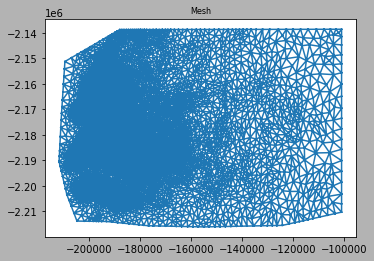

In [4]:
# Plot mesh
plotmodel(md,'data','mesh')

In [9]:
# Load parameters
md.geometry.bed = param_mat['geometry_bed']
md.geometry.surface = param_mat['geometry_surface']
md.geometry.base = param_mat['geometry_base']
md.mask.ice_levelset = param_mat['mask_ice_levelset']
md.mask.groundedice_levelset = param_mat['mask_groundedice_levelset']
md.inversion.vx_obs = param_mat['inversion_vx_obs']
md.inversion.vy_obs = param_mat['inversion_vy_obs']
md.inversion.vel_obs = param_mat['inversion_vel_obs']
md.initialization.vx = param_mat['initialization_vx']
md.initialization.vy = param_mat['initialization_vy']
md.initialization.vz = param_mat['initialization_vz']
md.initialization.vel = param_mat['initialization_vel']
md.friction.coefficient = param_mat['friction_coefficient']
md.materials.rheology_n = param_mat['rheology_n']
md.materials.rheology_B = param_mat['rheology_B']
md.basalforcings.groundedice_melting_rate = param_mat['basalforcings_groundedice_melting_rate']
md.basalforcings.floatingice_melting_rate = param_mat['basalforcings_floatingice_melting_rate']
md.smb.mass_balance = param_mat['smb_mass_balance']
md.basalforcings.geothermalflux = param_mat['basalforcings_geothermalflux']
md.stressbalance.spcvx = param_mat['stressbalance_spcvx']
md.stressbalance.spcvy = param_mat['stressbalance_spcvy']
md.stressbalance.spcvz = param_mat['stressbalance_spcvz']
md.stressbalance.referential = param_mat['stressbalance_referential']
md.stressbalance.loadingforce = param_mat['stressbalance_loadingforce']
md.masstransport.spcthickness = param_mat['masstransport_spcthickness']

# Set bed = base for grounded ice
md.geometry.base = md.geometry.bed
md.geometry.thickness = md.geometry.surface - md.geometry.base

md.friction.q = np.ones(md.mesh.numberofelements)
md.friction.p = np.ones(md.mesh.numberofelements)

md.flowequation.isSSA = 1
md.flowequation.vertex_equation = 2 * np.ones(md.mesh.numberofvertices)
md.flowequation.element_equation = 2 * np.ones(md.mesh.numberofelements)
md.flowequation.borderSSA = np.ones(md.mesh.numberofvertices)
md.flowequation.borderHO = np.ones(md.mesh.numberofvertices)
md.flowequation.borderFS = np.ones(md.mesh.numberofvertices)

md.mask.ocean_levelset = -md.mask.ice_levelset

from generic import generic
md.cluster = generic() #telling where to run issm

md.miscellaneous.name = 'SAtoES'

In [10]:
#import generic
#generic.__file__

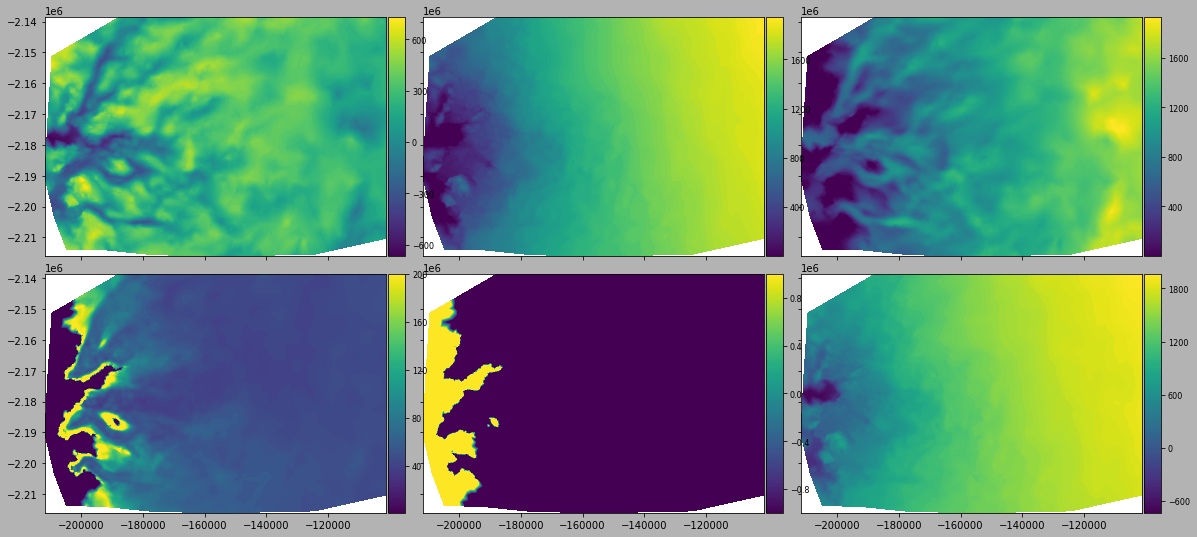

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

plotmodel(md, 'data', md.geometry.bed, \
              'data', md.geometry.surface, \
              'data', md.geometry.thickness, \
              'data', md.friction.coefficient, \
              'data', md.mask.ice_levelset, \
              'data', md.mask.groundedice_levelset)
              #'data', md.initialization.vel, 'caxis#3', [0, 1000],

if False:
    from solve import solve
    md = solve(md, 'sb')

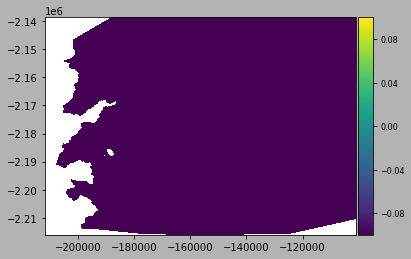

In [12]:
plotmodel(md, 'data', md.geometry.base - md.geometry.bed, 'mask', md.mask.ice_levelset<0)

In [13]:
# Step 3
## Inversion
#md = loadmodel('./Models/' +region+ '_Param.mat');
# Control general
md.inversion=m1qn3inversion(md.inversion);
md.inversion.iscontrol=1;
md.verbose.solution=False
md.verbose.control=True

# Cost functions
md.inversion.cost_functions=[101,103,501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)]);
md.inversion.cost_functions_coefficients[:,0]=2000;
md.inversion.cost_functions_coefficients[:,1]=40;
md.inversion.cost_functions_coefficients[:,2]=1.6e-06;

#Where vel==0, set coefficients to 0 (i.e., don't try to match this in model disp(['Removing vel==0 obs from inversion']);
#pos = find(md.inversion.vel_obs == 0);
#md.inversion.cost_functions_coefficients[pos,1] = 0;
#md.inversion.cost_functions_coefficients[pos,2] = 0;

#Controls
md.inversion.control_parameters=['FrictionCoefficient'];
md.inversion.maxsteps=50;
md.inversion.maxiter =50;
md.inversion.min_parameters=0.05*np.ones([md.mesh.numberofvertices,1]);
md.inversion.max_parameters=200*np.ones([md.mesh.numberofvertices,1]);
md.inversion.control_scaling_factors=1;

#Set basal friction coefficient initial guess to something low at front
filename = 'Exp/' +region+ '_coeffront.exp'
if os.path.isfile(filename):
  #disp(['Correcting basal friction coefficient initial guess for front inconsistencies']),
  flags = ContourToNodes(md.mesh.x,md.mesh.y,filename,2),
  #flags = md.inversion.vel_obs == 0;
  pos1 = np.where(flags)[0]
  #pos2 = np.where(~flags)[0]
  md.friction.coefficient[pos1] = 10

  md.inversion.max_parameters[pos1] = md.friction.coefficient[pos1]

#Additional parameters
md.stressbalance.restol=0.01;
md.stressbalance.reltol=0.1;
md.stressbalance.abstol=np.nan;
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

from solve import solve
md = solve(md,'Stressbalance')


converting inversion to m1qn3inversion
uploading input file and queueing script
launching solution sequence on remote cluster
cd /efs/issm/issm/trunk-jpl-denis/execution && rm -rf ./SAtoES-07-12-2022-16-19-06-1307 && mkdir SAtoES-07-12-2022-16-19-06-1307 && cd SAtoES-07-12-2022-16-19-06-1307 && mv ../SAtoES-07-12-2022-16-19-06-1307.tar.gz ./&& tar -zxf SAtoES-07-12-2022-16-19-06-1307.tar.gz  && chmod 755 SAtoES.queue && ./SAtoES.queue

Ice Sheet System Model (ISSM) version  4.19
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
   Initialize M1QN3 parameters
   Computing initial solution

Cost function f(x)   | Gradient norm |g(x)| |  List of contributions
____________________________________________________________________
f(x) =     284044.6  |             24.04802 |     943.4998     283081.4     19.77403
f(x) =     226100.2  |             1.738458 |     895.8694       225183     21.26019
f(x) =     225552.3  |             1.053364 |     873.829

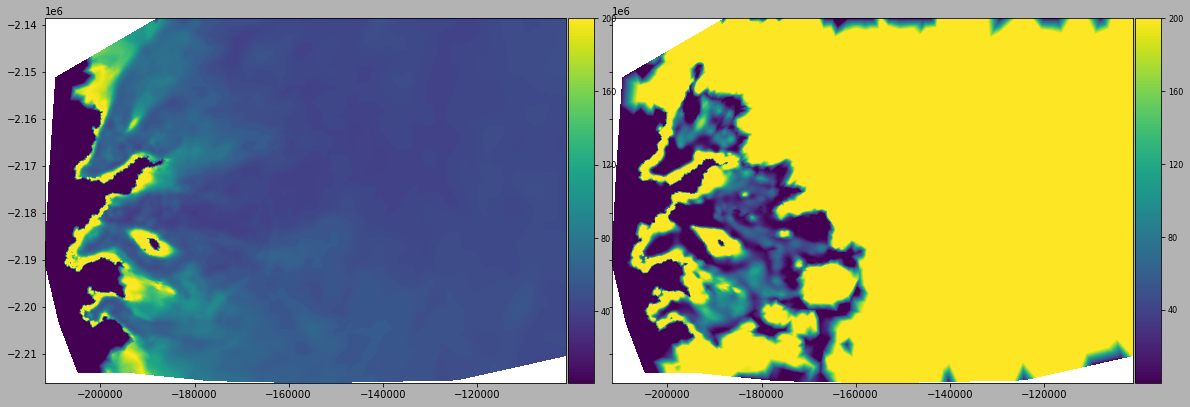

In [14]:
fig = plt.figure(figsize=(20,20))

plotmodel(md, 'data', md.friction.coefficient, 'data', md.results.StressbalanceSolution.FrictionCoefficient)

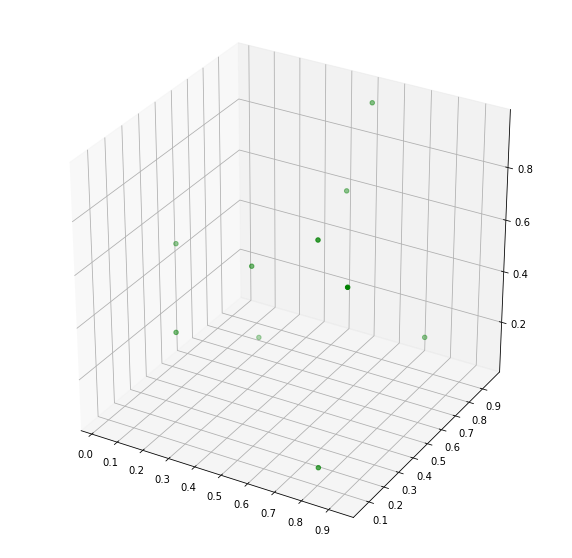

In [15]:
# from sahilm89/lhsmdu on Git

k = lhsmdu.sample(3, 10) # Latin Hypercube Sampling with multi-dimensional uniformity, 
                        # 3 variables with 10 samples each
k = np.array(k)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.set_xticks(np.arange(0,1,0.1))
ax.set_yticks(np.arange(0,1,0.1))
ax.scatter(k[0,:], k[1,:], k[2,:], color="g")
plt.show()

In [16]:
# Utilize LHS to vary model parameters

# collect -20% to 20% range
k = k * 0.4 - 0.2

# change initial model parameters to proportional LHS output
friction_after = md.friction.coefficient + md.friction.coefficient*k[0]
smb_mass_balance_after = md.smb.mass_balance + md.smb.mass_balance*k[1]
materials_rheology_B_after = md.materials.rheology_B + md.materials.rheology_B*k[2]

In [17]:
# test ensemble 1 & 2 for plotting
friction_after_ens1 = friction_after[:,0]
smb_mass_balance_ens1 = smb_mass_balance_after[:,0]
materials_rheology_B_ens1 = materials_rheology_B_after[:,0]
friction_after_ens2 = friction_after[:,1]
smb_mass_balance_ens2 = smb_mass_balance_after[:,1]
materials_rheology_B_ens2 = materials_rheology_B_after[:,1]

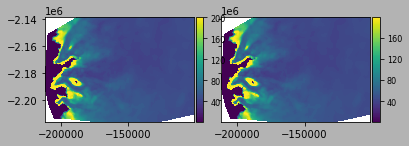

In [18]:
plotmodel(md, 'data', md.friction.coefficient, 'data', friction_after_ens1)

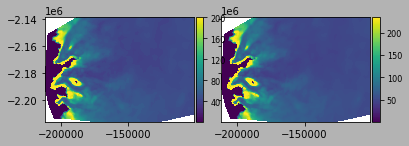

In [19]:
plotmodel(md, 'data', md.friction.coefficient, 'data', friction_after_ens2)

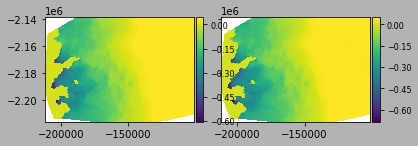

In [20]:
plotmodel(md, 'data', md.smb.mass_balance, 'data', smb_mass_balance_ens1)

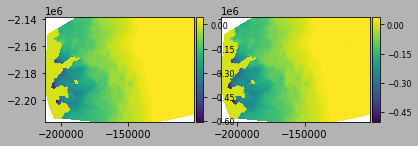

In [21]:
plotmodel(md, 'data', md.smb.mass_balance, 'data', smb_mass_balance_ens2)

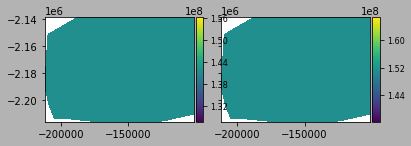

In [22]:
plotmodel(md, 'data', md.materials.rheology_B, 'data', materials_rheology_B_ens1)

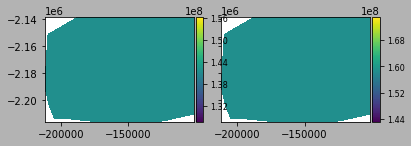

In [23]:
plotmodel(md, 'data', md.materials.rheology_B, 'data', materials_rheology_B_ens2)

In [24]:
# save pickle with issm module

data = {'friction_after': friction_after, 
        'smb_mass_balance_after': smb_mass_balance_after,
        'materials_rheology_B_after': materials_rheology_B_after
       }
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary 
    pickle.dump(data, f)

In [25]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

In [26]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1])

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [27]:
# We set the transient parameters
md.transient.ismovingfront=0
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the calving model (no moving front ... spclevelset is actually ignored)
md.levelset.spclevelset = md.levelset.spclevelset;
md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
md.calving.meltingrate = np.zeros([md.mesh.numberofvertices,1])

# Set bed = base for grounded ice
#md.geometry.base = md.geometry.bed
#md.geometry.thickness = md.geometry.surface - md.geometry.base

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default']

# Go solve
md.verbose.solution=1
md.cluster = generic()
md.settings.waitonlock = waitonlock
md = solve(md,'transient')

checking model consistency
marshalling file SAtoES.bin


TypeError: '>' not supported between instances of 'function' and 'int'

In [32]:
md.transient

   transient solution parameters:
         issmb                  : 1               -- indicates if a surface mass balance solution is used in the transient
         ismasstransport        : 1               -- indicates if a masstransport solution is used in the transient
         isoceantransport       : 0               -- indicates whether an ocean masstransport solution is used in the transient
         isstressbalance        : 1               -- indicates if a stressbalance solution is used in the transient
         isthermal              : 0               -- indicates if a thermal solution is used in the transient
         isgroundingline        : 1               -- indicates if a groundingline migration is used in the transient
         isesa                  : 0               -- indicates whether an elastic adjustment model is used in the transient
         isdamageevolution      : 0               -- indicates whether damage evolution is used in the transient
         ismovingfr